# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2022
- among others, this notebook can replicate the content of Table 4 as well as Figures 10-12
- it is assumed that pre-processed query events of individual teams are already generated and stored in cache/team_logs/[Year]/[TeamName]_events.pkl

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
unknownRankLimit = 1000
unknownRankValue = 2000
import pickle
import os
team_order = ['vibro','CVHunter', 'VISIONE', 'VERGE', 'vitrivr', 'vitrivr-VR']
team_order_no_vitrivr = ['vibro','CVHunter', 'VISIONE', 'VERGE', 'vitrivr-VR']

In [2]:
p = []
#removing vitrivr records because text data not present
teams = ["CVHunter","VERGE","vibro","VISIONE","vitrivr-VR","vitrivr"] #,"vitrivr"
year = "2022"
for t in teams:
    f = open("cache/team_logs/"+year+"/"+t+"_events.pkl","rb")
    p.append(pickle.load(f))
    
dataset = pd.concat(p)
dataset.head()

,task,team,user,is_user_with_correct_submission,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals
0,vbs22-kis-t01,CVHunter,0,1.0,1654506280000,20800.0,33594.0,2.0,2.0,2.0,TEXT,JointEmbedding,CLIP: close-up of motorbike exhaust pipe being...,
1,vbs22-kis-t01,CVHunter,0,1.0,1654506288000,28800.0,33594.0,inf,inf,inf,BROWSING,DetailWindowOpen,13964:7706,
2,vbs22-kis-t01,CVHunter,0,1.0,1654506291000,31800.0,33594.0,inf,inf,inf,BROWSING,DetailWindowClose,13964:7706,
3,vbs22-kis-t01,CVHunter,0,1.0,1654506292000,32800.0,33594.0,inf,inf,inf,SUBMIT,,?item=13964&frame=7694&session=node0tp720dt9nc...,"{""submission"":""CORRECT"" ""description"":""Submiss..."
4,vbs22-kis-t02,CVHunter,1,0.0,1654506776000,19112.0,173289.0,244.0,2168.0,508.0,TEXT,JointEmbedding,CLIP: wooden bridge seen from a creek,


In [3]:
dataset.category.unique()

array(['TEXT', 'BROWSING', 'SUBMIT', 'IMAGE', 'FILTER', 'Browsing',
       'SKETCH'], dtype=object)

In [4]:
dataset.groupby("team")["task"].nunique()

team
CVHunter      23
VERGE         22
VISIONE       23
vibro         23
vitrivr       23
vitrivr-VR    23
Name: task, dtype: int64

In [5]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.task=="vbs22-kis-t09"))]

,task,team,user,is_user_with_correct_submission,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals
89,vbs22-kis-t09,CVHunter,1,0.0,1654513103000,5086.0,26703.0,inf,inf,inf,BROWSING,RESET,,
90,vbs22-kis-t09,CVHunter,0,1.0,1654513116000,18086.0,26703.0,7.0,7.0,7.0,TEXT,JointEmbedding,CLIP: close-up shot of a yellow slug,
91,vbs22-kis-t09,CVHunter,1,0.0,1654513120000,22086.0,26703.0,2.0,2.0,2.0,TEXT,JointEmbedding,CLIP: yellow slug,
92,vbs22-kis-t09,CVHunter,0,1.0,1654513125000,27086.0,26703.0,inf,inf,inf,SUBMIT,,?item=06057&frame=34665&session=node0tp720dt9n...,"{""submission"":""CORRECT"" ""description"":""Submiss..."


### NOTES:
- VISIONE sends two (more?) queries if temporal, defined by "queryparameter":"Temporal_... and the same timestamp 
  - I plan to merge them together for the text analysis (query length and similar)
- vitrivr-VR has the same peculiarity, both query parts have the same timestamp and are distinguished by type= ".*0:jointEmbedding"
- VISIONE type="TEXT" with subtype "LocalizedObjectAndColors" does not really contain typed text, right? (i.e., "* -chairs3")
- CVHunter has some prefixes in the query which were not typed by the user (CLIP: / Temporal CLIP:) gonna remove them in pre-processing
- Task boundaries are currently missing (i.e., what task is solved by which queries). Could be appended centrally?
- vitrivr does not contain queried text values - is it an error of logging or pre-processing? Removed from analysis for now.
- are the logs free from queries processed after a correct submission (i.e., what if operators just played with their tools after they solved the task?)
  - if not, I gonna need times of correct submission for each team and boundaries for all tasks
  - and some verification that timestamps in the logs are correct


### Filtering and pre-processing
- merge Browsing and BROWSING
- remove category SUBMIT and type submission
- remove "LocalizedObjectAndColors"
- remove CVHunter prefixes from "value"
- remove some of CVHunter browsing types (those that does not alter ranking)

In [6]:
#remove incorrectly stored VISIONE logs
visioneSubmissions = dataset.loc[((dataset.team=="VISIONE")& (dataset["type"]=="submission"))]
dataset = dataset.loc[~((dataset.team=="VISIONE")& (dataset.timestamp.isin(visioneSubmissions.timestamp)))]

dataset = dataset.loc[dataset["type"]!="submission"]
dataset = dataset.loc[dataset["category"]!="SUBMIT"]
dataset = dataset.loc[~((dataset["team"]=="CVHunter")&(dataset["category"]=="BROWSING"))]
dataset.loc[dataset["type"].str.contains("LocalizedObjectAndColors"),"category"] = "FILTER"
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("Temporal CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(">","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(":","")
dataset.loc[dataset["category"]=="Browsing","category"] = "BROWSING"

dataset = dataset.loc[dataset["elapsed_since_task_start_ms"]>=0] 

In [7]:
dataset

,task,team,user,is_user_with_correct_submission,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals
0,vbs22-kis-t01,CVHunter,0,1.0,1654506280000,20800.0,33594.0,2.0,2.0,2.0,TEXT,JointEmbedding,close-up of motorbike exhaust pipe being cleaned,
4,vbs22-kis-t02,CVHunter,1,0.0,1654506776000,19112.0,173289.0,244.0,2168.0,508.0,TEXT,JointEmbedding,wooden bridge seen from a creek,
9,vbs22-kis-t02,CVHunter,0,1.0,1654506801000,44112.0,173289.0,14.0,14.0,14.0,TEXT,JointEmbedding,rocks hanging over a wooden walkway wooden br...,
10,vbs22-kis-t02,CVHunter,1,0.0,1654506848000,91112.0,173289.0,80.0,255.0,143.0,TEXT,JointEmbedding,rocks on the right and gorge on the left woode...,
16,vbs22-kis-t03,CVHunter,1,0.0,1654507338000,14558.0,33420.0,1.0,1.0,1.0,TEXT,JointEmbedding,caravan and a horse on a meadow,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,vbs22-kis-v12,vitrivr,1,NaN,1654600740675,211733.0,243583.0,inf,inf,inf,TEXT,,jointEmbedding,{}
407,vbs22-kis-v12,vitrivr,1,NaN,1654600742752,213810.0,243583.0,9.0,9.0,9.0,TEXT,,jointEmbedding,{}
409,vbs22-kis-v13,vitrivr,1,NaN,1654600925061,20292.0,41893.0,26.0,26.0,26.0,TEXT,,jointEmbedding,{}
410,vbs22-kis-v13,vitrivr,1,NaN,1654600927251,22482.0,41893.0,83.0,1175.0,1175.0,TEXT,,jointEmbedding,{}


In [8]:
dataset.shape

(1536, 14)

### VISIONE and vitrivr-VR merging temporal queries
- merge all text fileds made by the same operator at the same timestamp into a single row

In [9]:
visioneTemporal = dataset.loc[((dataset["team"]=="VISIONE")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
prev_timestamp = 0
newRows = []
visioneNonDuplicate = visioneTemporal.drop_duplicates(subset=["task","team","user","timestamp", "type"]) #add type


txtGroupby = visioneTemporal.groupby(["task","team","user","timestamp", "type"]).agg({'value': ' '.join}).reset_index() #add type   

for (idx, row) in txtGroupby.iterrows():    
    visioneNonDuplicate.loc[((visioneNonDuplicate.user==row["user"])&(visioneNonDuplicate.timestamp==row["timestamp"])),"value"] = row["value"]
dataset = dataset.loc[~((dataset["team"]=="VISIONE")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
dataset = pd.concat([dataset,visioneNonDuplicate])
dataset.shape

D:\Work\Dev\workspacePYTHON\PycharmProjects\VBS-log-analysis\venv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(1379, 14)

In [10]:
vitrivrvrTemporal = dataset.loc[((dataset["team"]=="vitrivr-VR")&(dataset["type"].str.contains('0:jointEmbedding')))]
prev_timestamp = 0
newRows = []
vitrivrvrNonDuplicate = vitrivrvrTemporal.drop_duplicates(subset=["task","team","user","timestamp"])


txtGroupby = vitrivrvrTemporal.groupby(["task","team","user","timestamp"]).agg({'value': ' '.join}).reset_index()    

for (idx, row) in txtGroupby.iterrows():    
    vitrivrvrNonDuplicate.loc[((vitrivrvrNonDuplicate.user==row["user"])&(vitrivrvrNonDuplicate.timestamp==row["timestamp"])),"value"] = row["value"]
dataset = dataset.loc[~((dataset["team"]=="vitrivr-VR")&(dataset["type"].str.contains('0:jointEmbedding')))]
dataset = pd.concat([dataset,vitrivrvrNonDuplicate])
dataset.shape

(1326, 14)

## Pre-processing from Konstantin
- defining several types of queries throughout participating teams

In [11]:
dataset["QT"] = "None"

In [12]:
# Text
dataset.loc[dataset["type"].str.contains("jointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("JointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("concept"),"QT"] = "Text"
dataset.loc[dataset["value"].str.contains("jointEmbedding"),"QT"] = "Text"
# ODLS
dataset.loc[dataset["type"].str.contains("LocalizedObjectAndColors"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("semanticSegmentation"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("numberOfObjects"),"QT"] = "ODLS"
# Sketch
dataset.loc[dataset["value"].str.contains("color"),"QT"] = "Color"
dataset.loc[dataset["type"].str.contains("dominantColor"),"QT"] = "Color"
# OCR
dataset.loc[dataset["type"].str.contains("OCR"),"QT"] = "OCR"
dataset.loc[dataset["value"].str.contains("ocr"),"QT"] = "OCR"
# IMAGE
dataset.loc[dataset["category"].str.contains("IMAGE"),"QT"] = "IMAGE"
#ASR
dataset.loc[dataset["QT"] == "None" ,"QT"] = "ASR"

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? [decided not to (vibro incompatibility)]
- Define visual vs textual tasks

In [13]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

In [14]:
dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["category"]=="TEXT","QueryLen"] = dataset.loc[dataset["category"]=="TEXT","value"].str.len()
dataset.loc[dataset["category"]=="TEXT","QueryWords"] = dataset.loc[dataset["category"]=="TEXT","value"].str.split().str.len()
#dummy data for vitrivr
dataset.loc[((dataset["team"]=="vitrivr")&(dataset["category"]=="TEXT")),"QueryLen"] = -1
dataset.loc[((dataset["team"]=="vitrivr")&(dataset["category"]=="TEXT")),"QueryWords"] = -1

dataset.head()

,task,team,user,is_user_with_correct_submission,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,QT,task_type,QueryLen,QueryWords
0,vbs22-kis-t01,CVHunter,0,1.0,1654506280000,20800.0,33594.0,2.0,2.0,2.0,TEXT,JointEmbedding,close-up of motorbike exhaust pipe being cleaned,,Text,textual,48,7
4,vbs22-kis-t02,CVHunter,1,0.0,1654506776000,19112.0,173289.0,244.0,2168.0,508.0,TEXT,JointEmbedding,wooden bridge seen from a creek,,Text,textual,31,6
9,vbs22-kis-t02,CVHunter,0,1.0,1654506801000,44112.0,173289.0,14.0,14.0,14.0,TEXT,JointEmbedding,rocks hanging over a wooden walkway wooden br...,,Text,textual,63,11
10,vbs22-kis-t02,CVHunter,1,0.0,1654506848000,91112.0,173289.0,80.0,255.0,143.0,TEXT,JointEmbedding,rocks on the right and gorge on the left woode...,,Text,textual,72,15
16,vbs22-kis-t03,CVHunter,1,0.0,1654507338000,14558.0,33420.0,1.0,1.0,1.0,TEXT,JointEmbedding,caravan and a horse on a meadow,,Text,textual,31,7


In [15]:
counts = dataset.groupby(["team","QT"])[["value"]].count()
((counts / dataset.groupby(["team"])[["value"]].count())*100).round(1)

value
team       QT          
CVHunter   IMAGE   17.8
           Text    82.2
VERGE      Color    1.4
           IMAGE    8.5
           ODLS     1.4
           Text    88.6
VISIONE    Color    0.3
           ODLS    21.1
           Text    78.5
vibro      Color    2.3
           IMAGE   27.8
           Text    69.9
vitrivr    ASR      6.0
           Color    2.6
           OCR      8.3
           ODLS     1.0
           Text    82.1
vitrivr-VR OCR      3.1
           Text    96.9

In [16]:
counts = dataset.groupby(["team","QT"])[["value"]].count()
counts.loc[((counts["value"]>=10)&(counts.index.get_level_values('QT')!="None"))]

value
team       QT          
CVHunter   IMAGE     28
           Text     129
VERGE      IMAGE     18
           Text     187
VISIONE    ODLS      61
           Text     227
vibro      IMAGE     49
           Text     123
vitrivr    ASR       18
           OCR       25
           Text     248
vitrivr-VR Text     185

In [17]:
#append dummy values for too high ratings (have to be labeled in plots properly in charts)
dataset.loc[dataset.rank_video > unknownRankLimit,"rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit,"rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit,"rank_shot_margin_5"] = unknownRankValue

In [18]:
textData = dataset.loc[dataset["category"]=="TEXT"]

In [19]:
restrData = dataset.loc[pd.Series(list(zip(dataset.team.values,dataset.QT.values))).isin(counts.index)]

### Comparison of visual and textual KIS tasks:

In [20]:
vt_counts = dataset.groupby(["task_type", 'QT'])[["value"]].count()
vt_counts = vt_counts.loc[((vt_counts.index.get_level_values('QT')!="None"))]
vt_counts

value
task_type QT          
textual   ASR        1
          Color     12
          IMAGE     26
          OCR       18
          ODLS      53
          Text     577
visual    ASR       17
          Color      4
          IMAGE     69
          OCR       13
          ODLS      14
          Text     522

In [21]:
vt_counts.div(vt_counts.groupby('task_type').transform('sum'))

value
task_type QT             
textual   ASR    0.001456
          Color  0.017467
          IMAGE  0.037846
          OCR    0.026201
          ODLS   0.077147
          Text   0.839884
visual    ASR    0.026604
          Color  0.006260
          IMAGE  0.107981
          OCR    0.020344
          ODLS   0.021909
          Text   0.816901

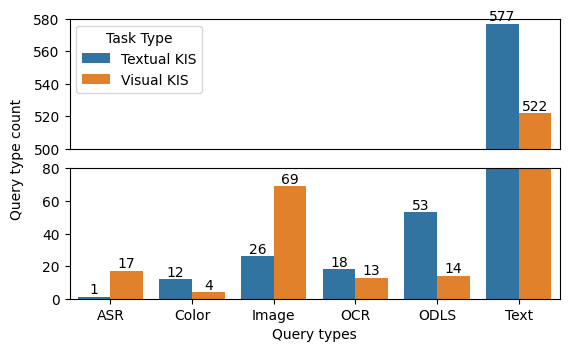

In [22]:
textual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "textual", "value"].tolist()
visual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "visual", "value"].tolist()

barplot_df = pd.DataFrame({
    'Query Types': ['ASR', 'Color', "Image", "OCR", "ODLS", "Text"],
    'Textual KIS': textual_values,
    'Visual KIS': visual_values
})

#fig, ax1 = plt.subplots(figsize=(7, 6))
tidy = barplot_df.melt(id_vars='Query Types').rename(columns=str.title)
tidy = tidy.rename(columns={"Value": "Query Type Count", "Variable": "Task Type", "Query Types": "Query types"})

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True, figsize=(7, 4))

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(500, 580)
ax2.set_ylim(0, 80)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.065, 0.5, "Query type count", va="center", rotation="vertical")

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
#ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
#ax2.legend(loc=(1.025, 0.5), title="Design")

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85, hspace=0.15)

for container in ax1.containers:
    ax1.bar_label(container)
for container in ax2.containers:
    ax2.bar_label(container)

plt.savefig(f'./query_type_vs_task_type.pdf', format='pdf', bbox_inches="tight")
plt.show()


In [23]:
textData = dataset.loc[dataset["category"]=="TEXT"]

In [24]:
restrData = dataset.loc[pd.Series(list(zip(dataset.team.values,dataset.QT.values))).isin(counts.index)]

### Comparison of visual and textual KIS tasks:

In [25]:
vt_counts = dataset.groupby(["task_type", 'QT'])[["value"]].count()
vt_counts = vt_counts.loc[((vt_counts.index.get_level_values('QT')!="None"))]
vt_counts

value
task_type QT          
textual   ASR        1
          Color     12
          IMAGE     26
          OCR       18
          ODLS      53
          Text     577
visual    ASR       17
          Color      4
          IMAGE     69
          OCR       13
          ODLS      14
          Text     522

In [26]:
vt_counts.div(vt_counts.groupby('task_type').transform('sum'))

value
task_type QT             
textual   ASR    0.001456
          Color  0.017467
          IMAGE  0.037846
          OCR    0.026201
          ODLS   0.077147
          Text   0.839884
visual    ASR    0.026604
          Color  0.006260
          IMAGE  0.107981
          OCR    0.020344
          ODLS   0.021909
          Text   0.816901

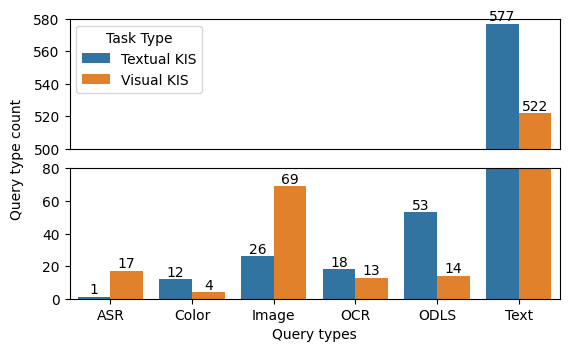

In [27]:
textual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "textual", "value"].tolist()
visual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "visual", "value"].tolist()

barplot_df = pd.DataFrame({
    'Query Types': ['ASR', 'Color', "Image", "OCR", "ODLS", "Text"],
    'Textual KIS': textual_values,
    'Visual KIS': visual_values
})

#fig, ax1 = plt.subplots(figsize=(7, 6))
tidy = barplot_df.melt(id_vars='Query Types').rename(columns=str.title)
tidy = tidy.rename(columns={"Value": "Query Type Count", "Variable": "Task Type", "Query Types": "Query types"})

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True, figsize=(7, 4))

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(500, 580)
ax2.set_ylim(0, 80)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.065, 0.5, "Query type count", va="center", rotation="vertical")

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
#ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
#ax2.legend(loc=(1.025, 0.5), title="Design")

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85, hspace=0.15)

for container in ax1.containers:
    ax1.bar_label(container)
for container in ax2.containers:
    ax2.bar_label(container)

plt.savefig(f'./query_type_vs_task_type.pdf', format='pdf', bbox_inches="tight")
plt.show()


### General per-team statistics from text queries:

In [28]:
medianStats = restrData.groupby(["team","QT"])[["QueryWords","QueryLen","rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()
medianStats

QueryWords  QueryLen  rank_shot_margin_0  \
team       QT                                                
CVHunter   IMAGE        -1.0      -1.0               163.0   
           Text          8.0      46.0               928.0   
VERGE      Color        -1.0      -1.0              2000.0   
           IMAGE        -1.0      -1.0              2000.0   
           ODLS         -1.0      -1.0              2000.0   
           Text          5.0      25.0               445.0   
VISIONE    Color        17.0      82.0              2000.0   
           ODLS         -1.0      -1.0              2000.0   
           Text         21.0     100.0               751.0   
vibro      Color        10.0      56.5              1014.0   
           IMAGE        -1.0      -1.0              2000.0   
           Text          8.0      38.0               481.0   
vitrivr    ASR          -1.0      -1.0              2000.0   
           Color        -1.0      -1.0              2000.0   
           OCR          -1.0      -1.0              2000.0   
           ODLS         -1.0      -1.0              2000.0   
           Text         -1.0      -1.0              2000.0   
vitrivr-VR OCR           1.5      10.0              2000.0   
           Text          6.0      29.0              2000.0   

                  rank_shot_margin_5  rank_video  
team       QT                                     
CVHunter   IMAGE               163.0        82.0  
           Text                843.0       489.0  
VERGE      Color              2000.0      2000.0  
           IMAGE              1492.5      1399.0  
           ODLS               2000.0      2000.0  
           Text                445.0       191.0  
VISIONE    Color              2000.0        48.0  
           ODLS               2000.0       656.0  
           Text                684.0       160.0  
vibro      Color                59.0         3.0  
           IMAGE               435.0       322.0  
           Text                374.0       113.0  
vitrivr    ASR                2000.0      2000.0  
           Color              2000.0      1434.0  
           OCR                2000.0      2000.0  
           ODLS               2000.0      2000.0  
           Text               2000.0       900.5  
vitrivr-VR OCR                2000.0      1121.5  
           Text               2000.0      2000.0

In [29]:
meanQueryStats = textData.groupby("team")[["QueryWords","QueryLen"]].mean()
meanQueryStats["QT"] = "Text"
meanQueryStats = meanQueryStats.set_index("QT", append=True)
meanQueryStats

,,QueryWords,QueryLen
team,QT,,
CVHunter,Text,9.139535,49.333333
VERGE,Text,4.486631,25.197861
VISIONE,Text,21.197368,103.890351
vibro,Text,8.086614,40.858268
vitrivr,Text,-1.000000,-1.000000
vitrivr-VR,Text,5.696335,28.366492


# Efectivity of text queries in general per team
- "topX" depict a percentage of queries, where the correct object was within top-x results
- ">1000" depict a percentage of queries whose results was worse than top-1000
### Finding correct scene

In [30]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_0 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","QT"]).count()["rank_shot_margin_0"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
resTab1 = topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

#in the end we want mean stats
resTab1["Words per query"] = meanQueryStats["QueryWords"]
resTab1["Query length"] = meanQueryStats["QueryLen"]
resTab1

C:\Users\lucia\AppData\Local\Temp\ipykernel_19348\2895578353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Words per query"] = meanQueryStats["QueryWords"]
C:\Users\lucia\AppData\Local\Temp\ipykernel_19348\2895578353.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Query length"] = meanQueryStats["QueryLen"]


Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   IMAGE             28              NaN           NaN   0.0   10.7   
           Text             129         9.139535     49.333333   7.8   10.9   
VERGE      IMAGE             18              NaN           NaN  11.1   11.1   
           Text             187         4.486631     25.197861   9.6   13.4   
VISIONE    ODLS              61              NaN           NaN   3.3   13.1   
           Text             227        21.197368    103.890351   5.7    9.7   
vibro      IMAGE             49              NaN           NaN   6.1   10.2   
           Text             123         8.086614     40.858268   4.1    7.3   
vitrivr    ASR               18              NaN           NaN   0.0    0.0   
           OCR               25              NaN           NaN   0.0    0.0   
           Text             248        -1.000000     -1.000000   1.2    3.2   
vitrivr-VR Text             185         5.696335     28.366492   0.0    0.0   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   IMAGE   14.3   39.3    42.9    57.1    64.3   32.1  
           Text    14.0   15.5    19.4    20.2    34.9   48.1  
VERGE      IMAGE   11.1   11.1    27.8    38.9    38.9   55.6  
           Text    14.4   23.0    32.1    45.5    54.0   38.0  
VISIONE    ODLS    19.7   19.7    23.0    26.2    39.3   54.1  
           Text    16.3   19.4    26.0    35.7    44.9   48.0  
vibro      IMAGE   14.3   20.4    30.6    32.7    46.9   51.0  
           Text    12.2   21.1    29.3    37.4    51.2   43.1  
vitrivr    ASR      5.6    5.6     5.6     5.6     5.6   94.4  
           OCR      0.0    0.0     4.0    12.0    12.0   88.0  
           Text     4.8    8.9    13.3    18.5    25.8   67.3  
vitrivr-VR Text     1.6    3.8     7.0    10.3    14.6   80.0

## Finding correct scene with slightly larger margins (+5sec)

In [31]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_5 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top5 = restrData.loc[restrData.rank_shot_margin_5 < 5].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top10 = restrData.loc[restrData.rank_shot_margin_5 < 10].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top20 = restrData.loc[restrData.rank_shot_margin_5 < 20].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top50 = restrData.loc[restrData.rank_shot_margin_5 < 50].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top100 = restrData.loc[restrData.rank_shot_margin_5 < 100].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top200 = restrData.loc[restrData.rank_shot_margin_5 < 200].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top500 = restrData.loc[restrData.rank_shot_margin_5 < 500].groupby(["team","QT"]).count()["rank_shot_margin_5"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   IMAGE             28             -1.0          -1.0   0.0   10.7   
           Text             129              8.0          46.0   7.8   10.9   
VERGE      IMAGE             18             -1.0          -1.0  11.1   11.1   
           Text             187              5.0          25.0   9.6   13.4   
VISIONE    ODLS              61             -1.0          -1.0   3.3   13.1   
           Text             227             21.0         100.0   5.7    9.7   
vibro      IMAGE             49             -1.0          -1.0   6.1   10.2   
           Text             123              8.0          38.0   4.1    7.3   
vitrivr    ASR               18             -1.0          -1.0   0.0    0.0   
           OCR               25             -1.0          -1.0   8.0    8.0   
           Text             248             -1.0          -1.0   1.2    3.2   
vitrivr-VR Text             185              6.0          29.0   0.5    0.5   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   IMAGE   14.3   39.3    42.9    57.1    64.3   32.1  
           Text    14.7   16.3    20.2    21.7    37.2   45.7  
VERGE      IMAGE   11.1   16.7    33.3    44.4    44.4   50.0  
           Text    15.0   23.5    33.7    45.5    54.5   37.4  
VISIONE    ODLS    19.7   19.7    23.0    29.5    42.6   50.8  
           Text    16.3   20.3    26.9    37.0    46.3   47.1  
vibro      IMAGE   14.3   24.5    34.7    34.7    55.1   42.9  
           Text    13.0   24.4    32.5    41.5    56.9   38.2  
vitrivr    ASR      5.6    5.6     5.6     5.6     5.6   94.4  
           OCR      8.0    8.0    12.0    20.0    20.0   80.0  
           Text     4.8    8.9    13.3    18.5    26.2   65.7  
vitrivr-VR Text     2.7    4.9     8.1    11.4    17.8   73.5

## Finding correct video

In [32]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_video > unknownRankLimit].groupby(["team","QT"]).count()["rank_video"]
top5 = restrData.loc[restrData.rank_video < 5].groupby(["team","QT"]).count()["rank_video"]
top10 = restrData.loc[restrData.rank_video < 10].groupby(["team","QT"]).count()["rank_video"]
top20 = restrData.loc[restrData.rank_video < 20].groupby(["team","QT"]).count()["rank_video"]
top50 = restrData.loc[restrData.rank_video < 50].groupby(["team","QT"]).count()["rank_video"]
top100 = restrData.loc[restrData.rank_video < 100].groupby(["team","QT"]).count()["rank_video"]
top200 = restrData.loc[restrData.rank_video < 200].groupby(["team","QT"]).count()["rank_video"]
top500 = restrData.loc[restrData.rank_video < 500].groupby(["team","QT"]).count()["rank_video"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   IMAGE             28             -1.0          -1.0   7.1   14.3   
           Text             129              8.0          46.0  10.1   14.0   
VERGE      IMAGE             18             -1.0          -1.0  27.8   27.8   
           Text             187              5.0          25.0  18.7   21.9   
VISIONE    ODLS              61             -1.0          -1.0   3.3   13.1   
           Text             227             21.0         100.0   7.0   12.8   
vibro      IMAGE             49             -1.0          -1.0   6.1   12.2   
           Text             123              8.0          38.0   8.9   14.6   
vitrivr    ASR               18             -1.0          -1.0   0.0    0.0   
           OCR               25             -1.0          -1.0   8.0    8.0   
           Text             248             -1.0          -1.0   1.2    4.0   
vitrivr-VR Text             185              6.0          29.0   0.5    1.1   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   IMAGE   21.4   42.9    53.6    60.7    71.4   28.6  
           Text    17.1   18.6    25.6    28.7    50.4   31.0  
VERGE      IMAGE   27.8   33.3    33.3    44.4    44.4   50.0  
           Text    24.1   33.7    36.9    50.3    61.5   29.4  
VISIONE    ODLS    19.7   26.2    29.5    39.3    49.2   34.4  
           Text    20.3   31.7    45.4    53.7    61.7   31.7  
vibro      IMAGE   14.3   30.6    40.8    40.8    59.2   34.7  
           Text    26.0   38.2    48.8    55.3    65.9   26.0  
vitrivr    ASR      5.6    5.6     5.6     5.6    22.2   77.8  
           OCR      8.0    8.0    12.0    20.0    24.0   64.0  
           Text     6.5   12.1    19.0    23.8    37.5   48.8  
vitrivr-VR Text     4.9    9.2    19.5    28.1    38.9   54.6

## Observations:
- vitrivr and vitrivr-VR had clearly inferior search/retrieval model (CLIP vs. not CLIP)
  - may be also due to the users, but I personally doubt it and rather blaim the retrieval model
- most of the teams got other query type results inferior as compared to the text queries
    - one notable exception is CVHunter, where IMAGE queries outperformed text queries for most top-k variants (true both for scenes and videos

As for the text queries:
- apart from both vitrivr, teams are quite close to each other, nonetheless:
  - VERGE good at small top-k, vibro rather the opposite
  - CVHunter largest share of beyond threshold results (">1000") except for vitrivr and vitrivr-VR
- VISIONE in general created lagest queries (QueryWords, QueryLen) as well as second most queries (after vitrivr) - but it may be biased by time to solve task (or they were just quicker to construct queries) - hard to set a righteous criteria (varying query lying intensity throughout the search process)

# Ranking vs. Query length and Query words

In [33]:
textDataWithLength = textData.loc[textData.QueryLen > -1]
textDataWithLength.shape

(862, 18)

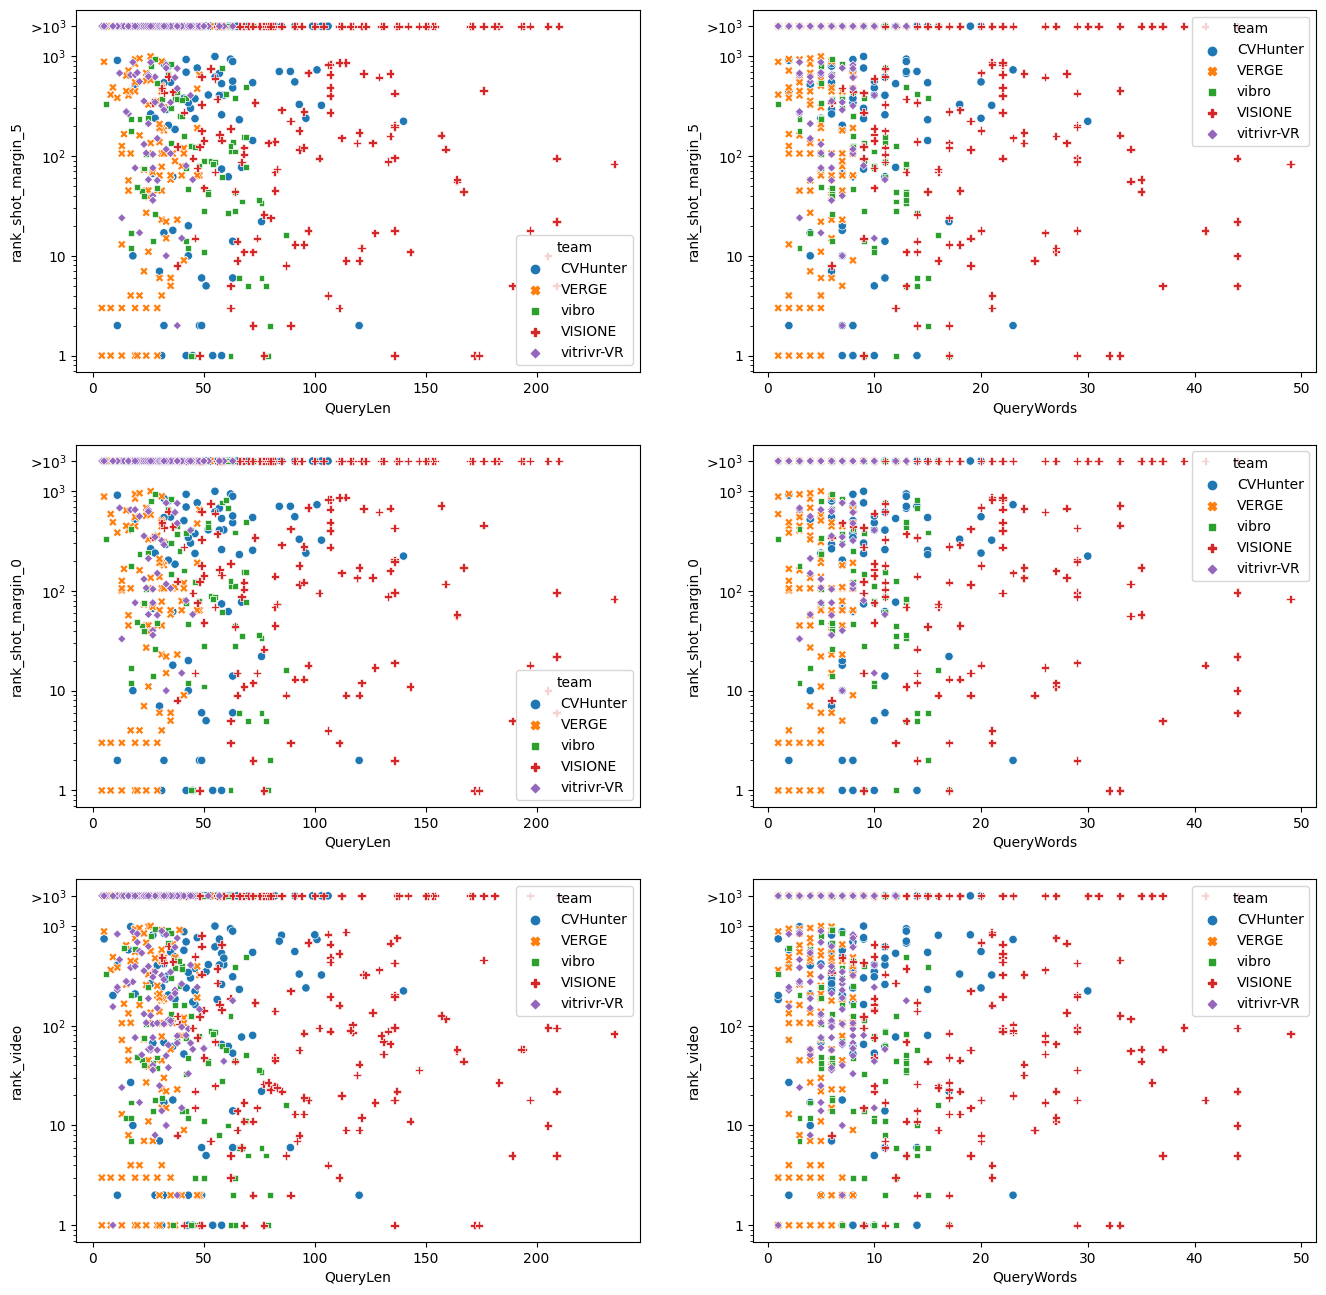

In [34]:
lenParam = ["QueryLen","QueryWords"]
resParam = ["rank_shot_margin_5","rank_shot_margin_0","rank_video"]

fig,ax = plt.subplots(3,2,figsize=(16,16))

for j,lenPar in enumerate(lenParam):
    for i,resPar in enumerate(resParam):
    
        sns.scatterplot(data=textDataWithLength,x=lenPar,y=resPar,style="team", hue="team", ax=ax[i,j])
        ax[i,j].set_yscale("log")

        ax[i,j].set_yticks([1,10,100,1000,2000])
        ax[i,j].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


- Really, not much to see, unfortunatelly. 
  - There is (very mild) negative correlation between rank and query length and #words
  - The difference rises up a bit when queries with >1000 results are considered, but not much

In [35]:
textDataKnownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 < unknownRankValue]
textDataUnknownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 >= unknownRankValue]
textDataKnownShotRanking[["QueryLen","QueryWords","rank_shot_margin_0"]].corr()

,QueryLen,QueryWords,rank_shot_margin_0
QueryLen,1.000000,0.990590,-0.074857
QueryWords,0.990590,1.000000,-0.072329
rank_shot_margin_0,-0.074857,-0.072329,1.000000


## Are there any dependencies between query length and ability to get decent ranks?
- comparing query statistics for ranks <=1000 and >1000

In [36]:
textDataUnknownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      49.384956
QueryWords     9.654867
dtype: float64

In [37]:
textDataKnownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      56.214634
QueryWords    11.224390
dtype: float64

In [38]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_shot_margin_0 <= 1000),"rankCat"] = "1-1000"
#textData.loc[textData.rank_shot_margin_0 <= 10,"rankCat"] = "1-10"
#textData.loc[((textData.rank_shot_margin_0 > 10)&(textData.rank_shot_margin_0 <= 100)),"rankCat"] = "11-100"
#textData.loc[((textData.rank_shot_margin_0 > 100)&(textData.rank_shot_margin_0 <= 1000)),"rankCat"] = "101-1000"

C:\Users\lucia\AppData\Local\Temp\ipykernel_19348\522766604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">1000"
D:\Work\Dev\workspacePYTHON\PycharmProjects\VBS-log-analysis\venv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='rankCat', ylabel='QueryLen'>

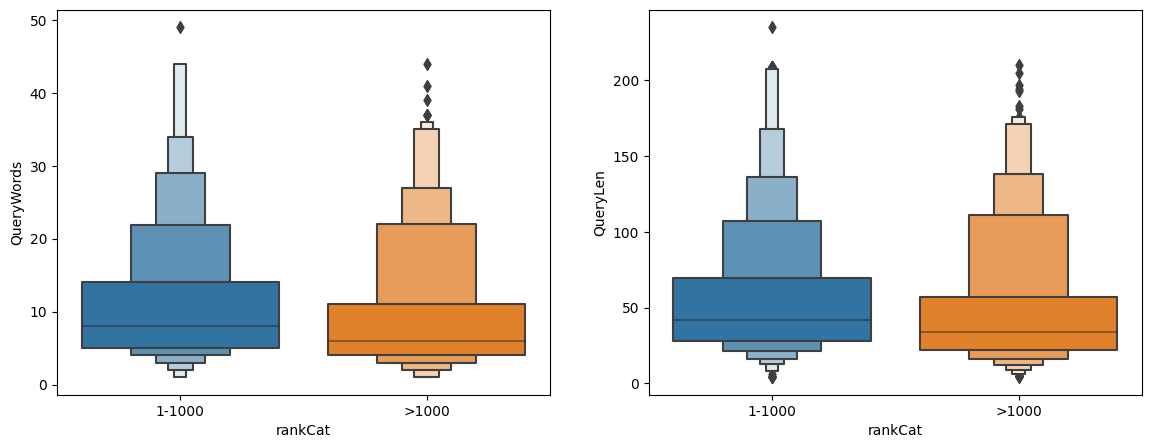

In [39]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", ax=ax[1])

In [40]:
from scipy.stats import ttest_ind
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryLen"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryLen"]))
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryWords"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryWords"]))

ModuleNotFoundError: No module named 'scipy'

- The difference between unsuccessful and successful queries is significant w.r.t. query len and query words
    - but it is hardly a comprehensive description (there are large overlaps)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1]
hue_order = team_order_no_vitrivr

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("TextQueryLengthVsRanking.pdf")

- there are very large differences in how individual teams lay queries
    - however, not much of whether they are successful or not depends on their outer characteristics (length)    

In [ ]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

In [ ]:
for team in textDataWithLength.team.unique():
    print(team)
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"].mean())
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"].mean())

- the difference is significant especially for vibro and VERGE teams as well as CVHunter w.r.t. QueryWords
- insignificant for vitrivr-VR

### The same for video rank

In [ ]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_video <= 1000),"rankCat"] = "1-1000"
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax[1])

In [ ]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

- For vibro and VERGE, out of range queries w.r.t. both videos and shots had significantly shorter queries w.r.t. both lengths and number of words in them

In [ ]:
textualMaxTime = 420000
visualMaxTime = 300000
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="textual")),"correct_submission_time_ms"] = textualMaxTime
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="visual")),"correct_submission_time_ms"] = visualMaxTime

In [ ]:
"""boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()"""

In [ ]:
boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()

## Intensity of laying queries over time
- 30 second intervals
- normalized by the volume of still compeeting teams+task within that time window

In [ ]:
#remove data that are from the histogram bins where the team submitted (i.e. did not continue throughout the bin duration)
validRestrData = dataset.copy()
print(validRestrData.shape)
for vb in valid_bins:
    validRestrData = validRestrData.loc[~((validRestrData[vb]==False)&(validRestrData["hist_bin"]>=int(vb.replace("valid_","")) ))]
print(validRestrData.shape)

In [ ]:
bin_divisors = validRestrData.groupby(["team","task"])[valid_bins].max().sum()
bin_divisors.index = bin_divisors.index.str.replace("valid_","").astype(int)

In [ ]:
hist_counts = validRestrData.groupby("hist_bin")["team"].count()

In [ ]:
(hist_counts / bin_divisors).plot.bar()
#TODO make the graph publication-ready (descriptions etc.)

In [ ]:
(hist_counts / bin_divisors)

### Observations:
- there are no huge differences, but still, the volume of queries per time tends to decrease a bit in the later stages of the search
- perhaps users already depleated ways to reformulate and focus more on the browsing
- the initial lower values are probably caused by the information processing gap (watching the scene, reading the description)

## Per-team querying density

In [ ]:
#total availabe time to ask queries per team
totTime = dataset.groupby(["team","task"])[["correct_submission_time_ms"]].min().reset_index().groupby("team")["correct_submission_time_ms"].sum()
totTime

In [ ]:
#per-team query density
queryCount = dataset.groupby("team")["task"].count()
queryCount

In [ ]:
queryPerMinute = queryCount/totTime*1000*60
queryPerMinute

In [ ]:
qpmdf = pd.DataFrame({"QPM":queryPerMinute})
qpmdf["QT"] = "Text"
qpmdf = qpmdf.set_index("QT", append=True)

In [ ]:
resTab1["Query per Minute"] = qpmdf["QPM"]
resTab1 = resTab1.loc[team_order, 
                      ['Text','IMAGE', 'ODLS', 'OCR'],
                      :]
print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2).to_latex())
#print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].to_latex())

In [ ]:
resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2)

### Observations:
- vitrivr-VR is notably slower in query construction (or just spent much more time in browsing - is it VR to blame?)
- VISIONE and vibro depended more heavily on querying

In [ ]:
queryCount = dataset.groupby(["team","user"])["task"].count()
queryCount

- does not look like so notable differences among individual users... skip for now

## Initial response time
- how quickly did individual teams managed to ask their first query?

In [ ]:
initTime = (dataset.groupby(["team","task","user","task_type"])[["elapsed_since_task_start_ms"]].min()/1000).reset_index()

In [ ]:
initTime.groupby(["team","task_type"]).mean()["elapsed_since_task_start_ms"]

In [ ]:
initTime.groupby(["team","task_type"]).median()["elapsed_since_task_start_ms"]

In [ ]:
initTime.groupby(["team","task_type"]).min()["elapsed_since_task_start_ms"]

In [ ]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.task=="vbs22-kis-t09"))]

In [ ]:
initTime.groupby(["task_type"]).mean()["elapsed_since_task_start_ms"]

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="task_type", ax=ax[0])
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="user", ax=ax[1])

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
initTime["Task type"] = "Textual KIS"
initTime.loc[initTime.task_type=="visual","Task type"] = "Visual KIS"

sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="Task type", ax=ax, order=team_order )

ax.set_xlabel("Teams")
ax.set_ylabel("Time to submit the first query (s)")
plt.tight_layout()
plt.savefig("TimeToFirstQueryPerTeam.pdf")

In [ ]:
print(ttest_ind(initTime.loc[initTime.team == "vitrivr-VR","elapsed_since_task_start_ms"],initTime.loc[initTime.team != "vitrivr-VR","elapsed_since_task_start_ms"]))

In [ ]:
print(ttest_ind(initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Textual KIS")),"elapsed_since_task_start_ms"],initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Visual KIS")),"elapsed_since_task_start_ms"]))

- not much difference between task types (a bit surprising, I was expecting longer times for visual tasks)
- vitrivr-VR has considerably & significantly larger times than all other teams (again, blaim VR or more focused on browsing from the beginning?)
- some variance between users, but not quite sure what to get from that...

# How (how much) reformulations help?

In [ ]:
ranks = []
lastRank = 0
lastRecord = (0,0,0)
#TODO: only for textual reformulations
sortedData = textData.sort_values(["task","team","user","timestamp"])
for idx, row in sortedData.iterrows():
    record = (row["task"],row["team"],row["user"])
    if record != lastRecord:
        lastRecord = record
        lastRank = 0
    lastRank += 1
    ranks.append(lastRank)

sortedData["QueryRank"] = ranks

#record how long was the interaction for each task and user
querySeriesLen = sortedData.groupby(["task","team","user"])[["QueryRank"]].max()
querySeriesLen.columns = ["MaxQueryRank"]
sortedData = sortedData.join(querySeriesLen, on=["task","team","user"])
sortedData.head()

In [ ]:
dt = sortedData.loc[((sortedData.QueryRank <= 4)&(sortedData.MaxQueryRank >= 4))]

fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", hue="team", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0", hue="team", ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

## Observations:
- quite notably, reformulation helps: throughout most of the teams and also in average
- there were multiple cases, when query results were quite good (10 - 10^2), but they were reformulated anyway -> blaim GUI?
- was thinking about directly comparing (previous - next) query ranks, but out-of-range results would make this comparison inconsistent

### The same, but counting query reformulations from the last query backwards 
- i.e., -3 denotes three queries before the last one made by the user for that particular task
- only sessions with 4+ queries were kept

In [ ]:
sortedData["DiffFromMaxQueryRank"] = sortedData.QueryRank - sortedData.MaxQueryRank
dt2 = sortedData.loc[((sortedData.DiffFromMaxQueryRank >= -3)&(sortedData.MaxQueryRank > 3))]
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

In [ ]:
sortedData["RankForViz"] = -1
sortedData.loc[sortedData["QueryRank"]==1,"RankForViz"] = 1
sortedData.loc[sortedData["QueryRank"]==2,"RankForViz"] = 2
#sortedData.loc[sortedData["QueryRank"]==3,"RankForViz"] = 3
sortedData.loc[sortedData["DiffFromMaxQueryRank"]==0,"RankForViz"] = 3

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,1, figsize=(6,4))

sns.boxenplot(data=dt2,x="RankForViz",y="rank_shot_margin_0",  ax=ax)
#sns.boxenplot(data=dt2,x="RankForViz",y="rank_video", ax=ax[1])


#ax[1].set_yscale("log")
#ax[1].set_yticks([1,10,100,1000,2000])
#ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
#ax[1].set_xlabel("Query order per task and user")
#ax[1].set_ylabel("Best rank of a shot from the correct video")

ax.set_yscale("log")
ax.set_yticks([1,10,100,1000,2000])
ax.set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
ax.set_xticklabels(["First","Second","Last"])
ax.set_xlabel("Query order per task and user")
ax.set_ylabel("Rank of the correct shot")

plt.tight_layout()
plt.savefig("QueryReformulation.pdf")


In [ ]:
#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.QueryRank == 1)&(sortedData.MaxQueryRank <= 7))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_shot_margin_0",  ax=ax[0])
sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_video", ax=ax[1])


ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


ax[1].set_ylabel("Best rank of a shot from the correct video")

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[0].set_ylabel("Rank of the correct shot")



In [ ]:

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_shot_margin_0",  ax=ax[1])
sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_video", ax=ax[0])


ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[0].set_xticklabels(["First","Second","Last"])
ax[0].set_xlabel("Query order per task and user")
ax[0].set_ylabel("Best rank of a shot from the correct video")

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
ax[1].set_xlabel("Query order per task and user")
ax[1].set_ylabel("Rank of the correct shot")

In [ ]:
dt2.groupby(["team","DiffFromMaxQueryRank"])[["rank_video","rank_shot_margin_0"]].median()